# Image inpainting over CIFAR-10

The purpose of this project is to build and train a neural network for image inpainting over the CIFAR-10 dataset. 

Inpainting is a restauration process where damaged, deteriorated, or missing parts of an artwork are filled in to present a complete image.

In our case, we create the portion of the image to be filled in by cropping a fixed size rectangular area from CIFAR-10 images.

The networks must be trained over the training set, and tested on the test set.
You can split the train set into a validation set, if you wish.

The metrics that will be used to evaluate you result is Mean Square Error.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.datasets import cifar10

Here we load the dataset.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 3s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


Let's see some examples.

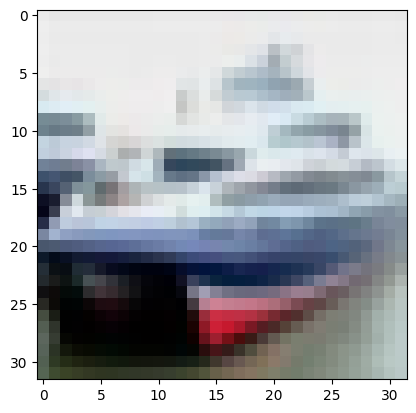

In [4]:
plt.imshow(x_test[1])
plt.show()

Now we hide a portion of the input, and the purpose of the network is to reconstruct it.

In [5]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

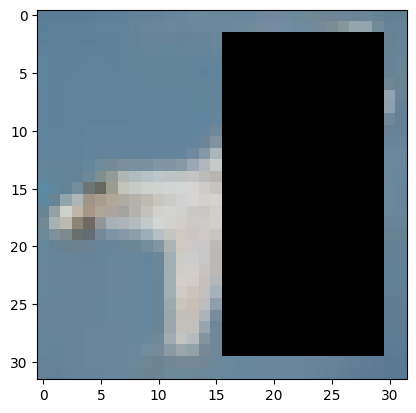

In [6]:
plt.imshow(masked_x_test[10])
plt.show()

In [7]:
print(x_test[0])

[[[0.61960787 0.4392157  0.19215687]
  [0.62352943 0.43529412 0.18431373]
  [0.64705884 0.45490196 0.2       ]
  ...
  [0.5372549  0.37254903 0.14117648]
  [0.49411765 0.35686275 0.14117648]
  [0.45490196 0.33333334 0.12941177]]

 [[0.59607846 0.4392157  0.2       ]
  [0.5921569  0.43137255 0.15686275]
  [0.62352943 0.44705883 0.1764706 ]
  ...
  [0.53333336 0.37254903 0.12156863]
  [0.49019608 0.35686275 0.1254902 ]
  [0.46666667 0.34509805 0.13333334]]

 [[0.5921569  0.43137255 0.18431373]
  [0.5921569  0.42745098 0.12941177]
  [0.61960787 0.43529412 0.14117648]
  ...
  [0.54509807 0.38431373 0.13333334]
  [0.50980395 0.37254903 0.13333334]
  [0.47058824 0.34901962 0.12941177]]

 ...

 [[0.26666668 0.4862745  0.69411767]
  [0.16470589 0.39215687 0.5803922 ]
  [0.12156863 0.34509805 0.5372549 ]
  ...
  [0.14901961 0.38039216 0.57254905]
  [0.05098039 0.2509804  0.42352942]
  [0.15686275 0.33333334 0.49803922]]

 [[0.23921569 0.45490196 0.65882355]
  [0.19215687 0.4        0.5803922 ]


# Approaches and evaluation

The network is supposed to take in input the masked image and fill in the missing part. 

You may basically follow two main approaches:
*   either you return the full image
*   you just return the missing crop

In the first case, the mse is to be evaluated on the full image; in the second case just on the crop (since on the reamining part is 0). 

If you want to take a different approach, you can ask for my approuval.



# What to deliver

As usual, you are supposed to deliver a single notebook comprising the code, the training history, and the evaluation on test data in terms of Mean Square Error.

Good work!

# Model
We use Generative Adversarial Networks (GANs) to perform image inpainting on CIFAR10. GANs are composed of two neural networks: a generator and a discriminator. The generator tries to create realistic images that match the input image except for the masked parts, while the discriminator tries to distinguish between real and fake images. The generator and the discriminator compete with each other and improve each other’s performance.

We use GANs for image inpainting because they can generate realistic and diverse results that preserve both global and local features of the image. They can also handle irregular and large masks that may be difficult for other methods. GANs are also flexible and can be adapted to different datasets and tasks.

We implement GANs on Keras, a high-level deep learning framework. We use an encoder-decoder architecture for the generator and a convolutional network for the discriminator. We train the GAN model with binary crossentropy loss and Adam optimizer. We use callbacks to save the generated images after each epoch and to stop training when there are no more improvements.

We evaluate the GAN model by visually inspecting the generated images and comparing them with the original images. We also use quantitative metrics such as peak signal-to-noise ratio (PSNR) and structural similarity index (SSIM) to measure the quality of the inpainted images.

In [8]:
# Import Keras modules
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential


In [70]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Concatenate
from tensorflow import keras as ks

## Generator
It's a UNET, whose last layer is a Lambda layer which allows to generate only the masked region, leaving the rest unchanged

In [40]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2): 
    #L=num of floors,
    #conv_per_L = num of conv layers in each floor

    #INPUT
    x=Input(shape=input_shape) #first input layer
    h=x

    #DOWN
    backup_layers=[]
    for l in range(L):
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding="same")(h) #conv
            h = BatchNormalization()(h) #batch norm
            h = LeakyReLU(alpha=0.1)(h) #leaky relu
        if l<L-1:
            backup_layers.append(h) #save layer for the SKIPS (BEFORE DOWNSAMPLING!!!)
            h= MaxPooling2D(padding="same")(h)
            n_ch=n_ch*2 #double channels


    #UP
    for l in range(L-1):
        n_ch=n_ch//2 #divide channels
        h=UpSampling2D()(h)#upsample
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])

        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding="same")(h) #conv
            h = BatchNormalization()(h) #batch norm
            h = LeakyReLU(alpha=0.1)(h) #leaky relu
            h = Dropout(0.2)(h) #dropout

    #OUTPUT
    y=Conv2D(3,1, activation="sigmoid")(h) #last layer is still Conv2D (FULLY CONVOLUTIONAL!). Activation is SIGMOID since it's a BINARY CLASSIFICATION
    replacement_layer = layers.Lambda(lambda x: tf.where(tf.equal(x[0], 0), x[1], x[0]))([x, y])

    return Model(x,replacement_layer)
  

## Discriminator
It has two inputs:
- masked image: x
- inpainted image: y (could be both real or fake)

The discriminator has to decide wheter y is real or fake

In [71]:
def build_discriminator(input_shape=(32, 32, 3)):
  # Input layer for the original image
  x = Input(shape=input_shape)
  # Input layer for the inpainted image
  y = Input(shape=input_shape)
  # Concatenate the two images along the channel dimension
  z = Concatenate(axis=-1)([x, y])
  h = z

  # Convolutional layers
  h = Conv2D(64, 3, 2, padding="same")(h) # Downsample
  h = LeakyReLU(alpha=0.1)(h) # Leaky ReLU
  h = Conv2D(128, 3, 2, padding="same")(h) # Downsample
  h = BatchNormalization()(h) # Batch norm
  h = LeakyReLU(alpha=0.1)(h) # Leaky ReLU

  # Flatten and output layer
  h = Flatten()(h)
  validity = Dense(1)(h) # Linear output

  return Model([x,y], validity)


## Add together
Create a custom GAN model class. <br>
**Using this [guide](https://medium.com/dive-into-ml-ai/customization-of-model-fit-to-write-a-combined-discriminator-generator-gan-trainer-in-keras-524bce10cf66) as reference**

In [ ]:
class GAN (Keras.Model):
  def __init__(self, discriminator, generator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.discriminator = discriminator
    self.generator = generator
  def train_step(self, data):
    masked_samples, original_imgs= data

    # Generate inpainted images from the generator model
    inpainted_imgs = generator.predict(masked_samples, verbose=0)
    original_imgs = x_train[indexes]
    # Assign labels for real and inpainted images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    # Train the discriminator on real and inpainted images separately
    d_loss_real = discriminator.train_on_batch([masked_samples, original_imgs], real_labels)
    d_loss_fake = discriminator.train_on_batch([masked_samples, inpainted_imgs], fake_labels)
    # Compute the average discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # Train the generator via the discriminator model
    g_loss = generator.train_on_batch(masked_samples, inpainted_imgs)

The code below is a mess, but could be useful

In [78]:
batch_size=64
epochs=10
num_batches = x_train.shape[0] // batch_size

input_size=(32,32,3)

# Create a generator model using the build_unet method
generator = build_unet(input_shape=input_size)

# Create a discriminator model using the build_discriminator method
discriminator = build_discriminator(input_shape=input_size)

# Compile the generator model with mean squared error loss and SGD optimizer
generator.compile(loss="mean_squared_error", optimizer=optimizers.AdamW(learning_rate=0.0002, beta_1=0.5))
#generator.load_weights("inpainting_unet.h5")
# Compile the discriminator model with binary crossentropy loss and SGD optimizer
discriminator.compile(loss="binary_crossentropy", optimizer=optimizers.AdamW(learning_rate=0.0002, beta_1=0.5))

# Train the generator and discriminator models for some epochs
def train_step(masked_samples):

  # Generate inpainted images from the generator model
  inpainted_imgs = generator.predict(masked_samples, verbose=0)
  original_imgs = x_train[indexes]
  # Assign labels for real and inpainted images
  real_labels = np.ones((batch_size, 1))
  fake_labels = np.zeros((batch_size, 1))
  # Train the discriminator on real and inpainted images separately
  d_loss_real = discriminator.train_on_batch([masked_samples, original_imgs], real_labels)
  d_loss_fake = discriminator.train_on_batch([masked_samples, inpainted_imgs], fake_labels)
  # Compute the average discriminator loss
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  # Train the generator via the discriminator model
  g_loss = generator.train_on_batch(masked_samples, inpainted_imgs)
  # Print the progress
  print("\r") 
  print("Epoch %d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))


batch 0/781

batch 1/781

batch 2/781

batch 3/781

batch 4/781

batch 5/781

batch 6/781

batch 7/781

batch 8/781

batch 9/781

batch 10/781

batch 11/781

batch 12/781

batch 13/781

batch 14/781

batch 15/781

batch 16/781

batch 17/781

batch 18/781

batch 19/781

batch 20/781

batch 21/781

batch 22/781

batch 23/781

batch 24/781

batch 25/781

batch 26/781

batch 27/781

batch 28/781

batch 29/781

batch 30/781

batch 31/781

batch 32/781

batch 33/781

batch 34/781

batch 35/781

batch 36/781

batch 37/781

batch 38/781

batch 39/781

batch 40/781

batch 41/781

batch 42/781

batch 43/781

batch 44/781

batch 45/781

batch 46/781

batch 47/781

batch 48/781

batch 49/781

batch 50/781

batch 51/781

batch 52/781

batch 53/781

batch 54/781

batch 55/781

batch 56/781

batch 57/781

batch 58/781

batch 59/781

batch 60/781

batch 61/781

batch 62/781

batch 63/781

batch 64/781

batch 65/781

batch 66/781

batch 67/781

batch 68/781

batch 69/781

batch 70/781

batch 71/781

ba

KeyboardInterrupt: ignored

## Training (only unet)


In [41]:
from tensorflow.keras.callbacks import Callback
epochs=30
batch_size=32
input_size=(32,32,3)

# Create a UNET
unet=build_unet(input_size, n_ch=32, L=2, conv_per_L=3)
unet.compile(loss="mean_squared_error", optimizer=optimizers.AdamW(learning_rate=0.0002, beta_1=0.5))



# Define a callback to stop training when there are no more improvements
class EarlyStopping(Callback):
  def __init__(self, patience):
    self.patience = patience # Number of epochs with no improvement to stop training
    self.best_loss = np.inf # Best loss value so far
    self.wait = 0 # Number of epochs with no improvement so far

# Create instances of the callbacks
early_stopping = EarlyStopping(patience=3)

print(unet.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 32, 32, 32)  128         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_34 (LeakyReLU)     (None, 32, 32, 32)   0           ['batch_normalization_34[0]

In [59]:
unet.load_weights("inpainting_unet.h5")
unet.fit(masked_x_train, x_train,epochs=20, batch_size=batch_size, validation_split=0.1, shuffle=True)
unet.save_weights("inpainting_unet.h5")

Epoch 1/20
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 2/20
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 3/20
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 4/20
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 5/20
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 6/20
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 7/20
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/20
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 9/20
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 10/20
1407/1407 [==============================] - 24s 17m

KeyboardInterrupt: ignored

# Testing

In [53]:
predictions=unet.predict(x=masked_x_test, verbose=0)


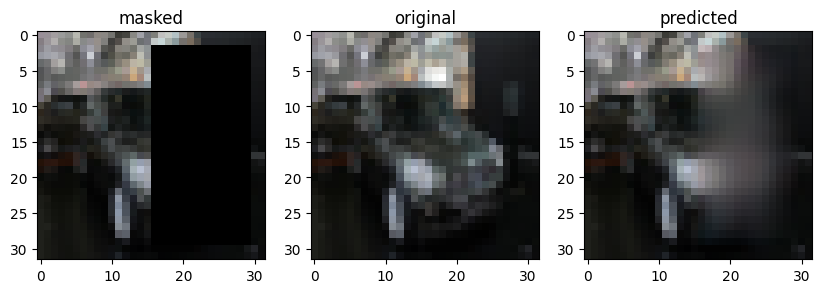

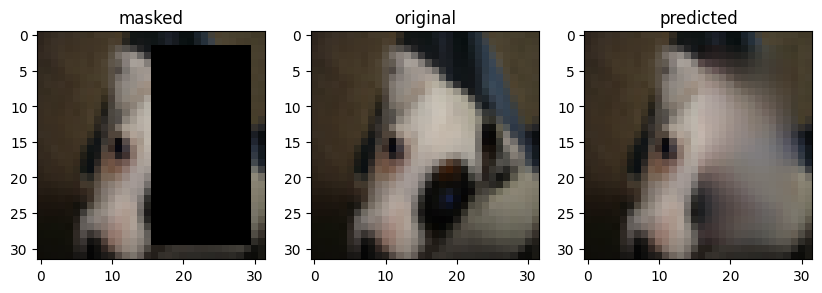

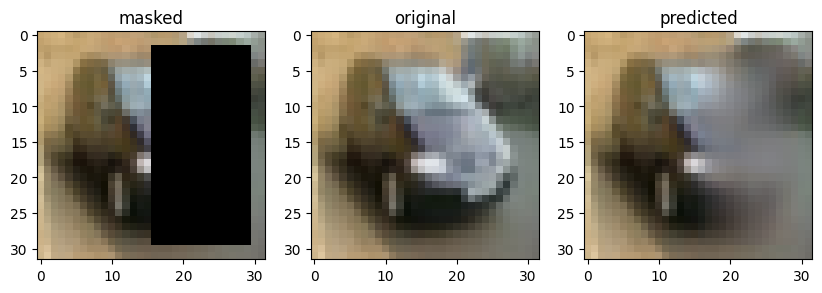

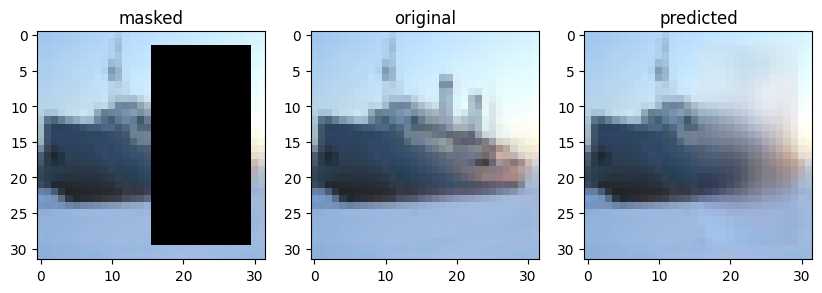

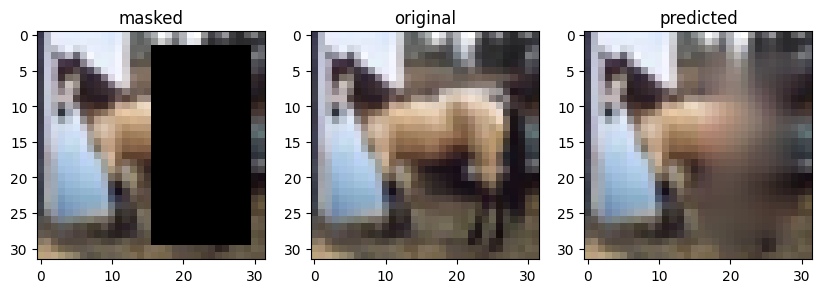

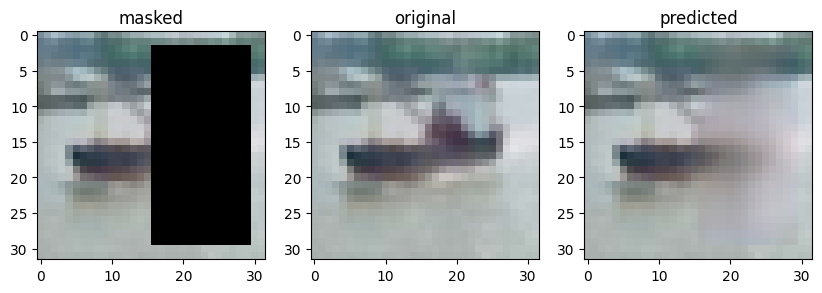

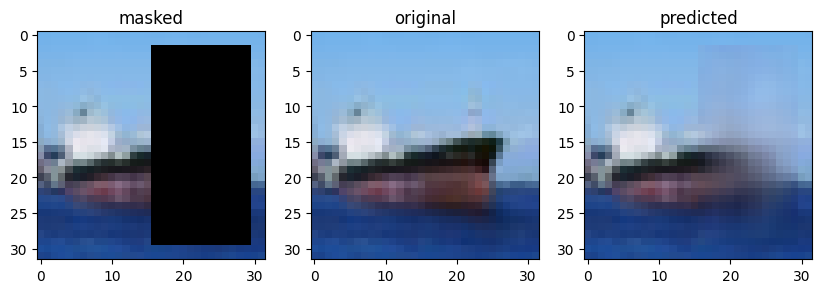

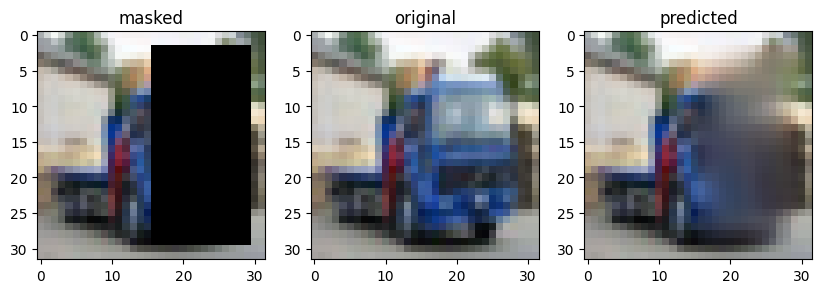

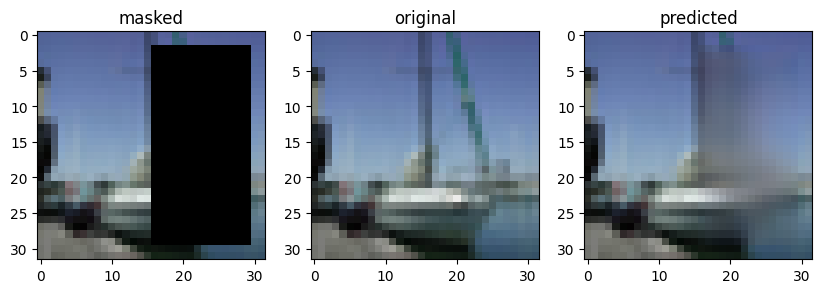

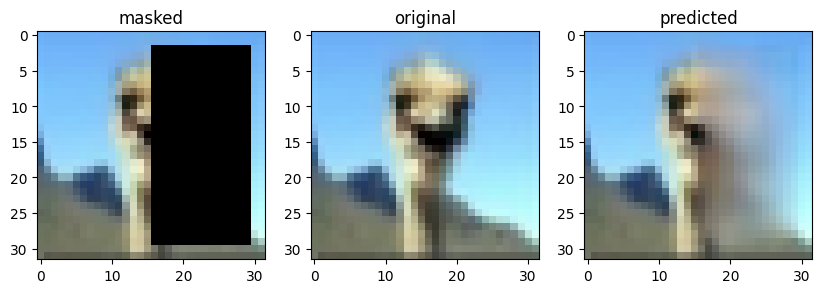

In [63]:
def test(index):
  plt.figure(figsize=(10,5))

  plt.subplot(1,3,1)
  plt.title("masked")
  plt.imshow(masked_x_test[index])

  plt.subplot(1,3,2)
  plt.title("original")
  plt.imshow(x_test[index])

  plt.subplot(1,3,3)
  plt.title("predicted")
  plt.imshow(predictions[index])
for i in np.random.randint(0, x_test.shape[0], size=10):
  test(i)

In [62]:
from keras import backend as K
mse = K.mean(K.square(x_test - predictions))
print("mean squared error:", K.eval(mse))


mean squared error: 0.00824229
